<a href="https://colab.research.google.com/github/alirezakhaleghianaghizi/MLC/blob/main/code_live.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kmodes
# pandas, numpy, sklearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from kmodes.kmodes import KModes
from sklearn.metrics import confusion_matrix, accuracy_score

In [12]:
df = pd.read_csv("dataset.csv")

effort_clustering = KMeans(n_clusters=2, random_state=0).fit(df[['time_online', 'video_clicks']])
df['effort'] = effort_clustering.labels_

proactivity_clustering = KMeans(n_clusters=2, random_state=0).fit(df[['content_anticipation', 'delay_lectures']])
df['proactivity'] = proactivity_clustering.labels_

control_clustering = KMeans(n_clusters=2, random_state=0).fit(df[['fraction_spent']])
df['control'] = control_clustering.labels_

df.to_csv("dataset_clustered.csv", index=False)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [13]:
k_modes = KModes(n_clusters=4)
clusters = k_modes.fit_predict(df[['effort', 'proactivity', 'control']])
df['profile'] = clusters
df.to_csv("dataset_clustered.csv", index=False)

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

features = df[["time_online", "video_clicks", "content_anticipation", "delay_lectures", "fraction_spent"]].values
target = df['grade'].values

scaler = StandardScaler()
features = scaler.fit_transform(features)

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=0)

X_train = torch.Tensor(X_train)
y_train = torch.Tensor(y_train).unsqueeze(1)
X_test = torch.Tensor(X_test)
y_test = torch.Tensor(y_test).unsqueeze(1)

class Net(nn.Module):
    def __init__(self, input_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, 10)
        self.fc2 = nn.Linear(10, 8)
        self.fc3 = nn.Linear(8, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

input_size = features.shape[1]
model = Net(input_size)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

for i in range(1000):
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [34]:
print(len(set(target)))

9


In [15]:
model.eval()
with torch.no_grad():
    y_pred = model(X_test)
    mse = F.mse_loss(y_pred, y_test)
    print(mse.item())

1.0488351583480835


در زیر به جای استفاده از داده های خام از داده های کلاستر شده استفاده کردیم و نتیجه را با روش قبلی میسنجیم.


In [21]:
features2 = df[["effort", "proactivity", "control","profile"]].values
target2 = df['grade'].values

scaler = StandardScaler()
features2 = scaler.fit_transform(features2)

X_train2, X_test2, y_train2, y_test2 = train_test_split(features2, target2, test_size=0.2, random_state=0)

X_train2 = torch.Tensor(X_train2)
y_train2 = torch.Tensor(y_train2).unsqueeze(1)
X_test2 = torch.Tensor(X_test2)
y_test2 = torch.Tensor(y_test2).unsqueeze(1)

input_size2 = features2.shape[1]
model2 = Net(input_size2)

criterion = nn.MSELoss()
optimizer = optim.Adam(model2.parameters(), lr=0.01)

for i in range(1000):
    outputs = model2(X_train2)
    loss2 = criterion(outputs, y_train)
    optimizer.zero_grad()
    loss2.backward()
    optimizer.step()

In [22]:
model2.eval()
with torch.no_grad():
    y_pred2 = model2(X_test2)
    mse2 = F.mse_loss(y_pred2, y_test2)
    print(mse2.item())

0.8674525618553162


نتیجه در حالتی که از بعد ها استفاده کردیم بهتر شده و نسبت به داده های خام خطای ما کمتر است

حال با روش لوجستیک رگرسیون میاییم و لرن میکنیم.

In [42]:
model3 = LogisticRegression(max_iter=500)
model3.fit(X_train,y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(max_iter=500)

In [48]:
y_pred3 = model3.predict(X_test)
mse3=0
for i in range(len(y_pred3)):
  mse3 += (y_pred3[i]-y_test[i])*(y_pred3[i]-y_test[i])

mse3=mse3/len(y_pred3)
print(np.array(mse3)[0])

1.1171172


با روش رگرسیون لوجستیک روی داده های اصلی و خام خطا  ما نسبت به مدل شبکه عصبی با داده های خام کمی بیشتر شده است ولی زیاد تغییر نکرده است در حد 10 درصد

In [49]:
model4 = LogisticRegression(max_iter=500)
model4.fit(X_train2,y_train2)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(max_iter=500)

In [50]:
y_pred4 = model4.predict(X_test2)
mse4=0
for i in range(len(y_pred4)):
  mse4 += (y_pred4[i]-y_test2[i])*(y_pred4[i]-y_test2[i])

mse4=mse4/len(y_pred4)
print(np.array(mse4)[0])

1.009009


با داده های غیر خام نیز خطا نسبت به داده های خام کمتر شده است ولی نسبت به شبکه عصبی حدود بیست و پنج درصد بیشتر شده است

<ipython-input-51-1fa7750dafca>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ypoints = np.array([mse,mse2,mse3,mse4])


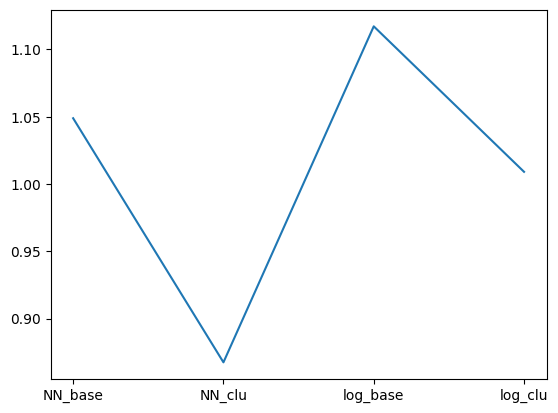

In [51]:
import matplotlib.pyplot as plt
import numpy as np

xpoints = np.array(["NN_base","NN_clu","log_base","log_clu"])
ypoints = np.array([mse,mse2,mse3,mse4])

plt.plot(xpoints, ypoints)
plt.show()

همانطور که در مدل شکل بالا میبینیم برای مدل هایی که با داده های کلاستر شده ترین شده اند مقدار خطای نتست ما نسبت به مدل بترین شده با داده های خام کمتر بوده است و همجنین میبینیم که در هر دو حالت خطا برای شبکه عصبی کمتر بوده است البته این مقدار اختلاف بسیار کم است و نززدیک هم هستند .

پس در کل کلاستر کردن داده ها نتیجه بهتری به ما میدهد تا این که از داده های خام اصلی استفاده کنیم.